# Natural Language Processing

We will be exploring some basic methods in natural language processing on the dataset given by [Issa Annamoradnejad & Gohar Zoghi](https://arxiv.org/abs/2004.12765). The dataset consists of 20,000 tweets that are split evenly between humourous and non-humourous.

***CONFESSION:*** Towards the end of this project I note an important mistake in my method that I then correct, although I believe it is helpful in highlighting the importance of a proper workflow and clear pipeline in data handling.

In [15]:
import os
import string
import numpy as np
import pandas as pd
import nltk
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

Below shows the format of the data we are provided.

In [16]:
tweetData = pd.read_csv("dataset.csv")
tweetData.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


Normalizing and encoding text for natural language processing looks like the following in its most crude form, using one-hot-vector encoding and ignoring any "stop-words" or tokens consisting of more than one word that make be worth considering. The text is stripped of all punctuation and put in lowercase.

In [17]:
class Vectorizer:
    
        def standardize(self, text):
            text = text.lower()
            return ''.join([char for char in text if char not in string.punctuation])
        
        def tokenize(self, text):
            text = self.standardize(text)
            return text.split()
        
        def makeVocabulary(self, dataset):
            self.vocabulary = {"": 0, "UNK": 1}
            for text in dataset:
                text = self.standardize(text)
                tokens = self.tokenize(text)
                for token in tokens:
                    if token not in self.vocabulary:
                        self.vocabulary[token] = len(self.vocabulary)
            self.inverseVocabulary = dict((v,k) for k,v in self.vocabulary.items())
            
        def encode(self, text):
            text = self.standardize(text)
            tokens = self.tokenize(text)
            return [self.vocabulary.get(token, 1) for token in tokens]
        
        def decode(self, integerSequence):
            return " ".join(self.inverseVocabulary.get(i, "UNK") for i in integerSequence)

In [18]:
vectorizer = Vectorizer()
vectorizer.makeVocabulary(tweetData['text'])

In [19]:
tweetInputs = [vectorizer.encode(tweetData['text'][i]) for i in range(len(tweetData))]
tweetOutputs = tweetData['humor']

Here is how our text is encoded.

In [20]:
print(f"Encoded:  {tweetInputs[10000]}")
print(f"Decoded:  {vectorizer.decode(tweetInputs[10000])}")
print(f"Humorous: {tweetOutputs[10000]}")

Encoded:  [4271, 4489, 11933, 12023, 289, 8160, 98, 870, 511, 684, 169]
Decoded:  natural ball lightning recorded by scientists for first time ever video
Humorous: False


# SKLearn Implementation

We load the data fresh again, and split into a training and testing set.

In [37]:
tweetData = pd.read_csv("dataset.csv")

tweetInputs = tweetData['text']
tweetOutputs = tweetData['humor']

tweetInputsTrain, tweetInputsTest, tweetOutputsTrain, tweetOutputsTest = train_test_split(tweetInputs, tweetOutputs,
                                                                                         test_size=0.3, random_state=1)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
countVectorizer = CountVectorizer()
tweetInputsTrain = countVectorizer.fit_transform(tweetInputsTrain)
tweetInputsTest = countVectorizer.transform(tweetInputsTest)

And we train a multilayer perceptron model using mostly the default parameters.

In [40]:
%%time
mlpClassifier = MLPClassifier(hidden_layer_sizes=(5, 2), verbose=True, random_state=1).fit(tweetInputsTrain, tweetOutputsTrain)

Iteration 1, loss = 0.64827901
Iteration 2, loss = 0.42578289
Iteration 3, loss = 0.30574905
Iteration 4, loss = 0.23189024
Iteration 5, loss = 0.18568592
Iteration 6, loss = 0.15521202
Iteration 7, loss = 0.13443431
Iteration 8, loss = 0.11918007
Iteration 9, loss = 0.10737159
Iteration 10, loss = 0.09671477
Iteration 11, loss = 0.08779935
Iteration 12, loss = 0.08032873
Iteration 13, loss = 0.07336442
Iteration 14, loss = 0.06734070
Iteration 15, loss = 0.06210211
Iteration 16, loss = 0.05700508
Iteration 17, loss = 0.05275607
Iteration 18, loss = 0.04925724
Iteration 19, loss = 0.04607141
Iteration 20, loss = 0.04334154
Iteration 21, loss = 0.04129612
Iteration 22, loss = 0.03940484
Iteration 23, loss = 0.03759594
Iteration 24, loss = 0.03601476
Iteration 25, loss = 0.03560125
Iteration 26, loss = 0.03476642
Iteration 27, loss = 0.03440544
Iteration 28, loss = 0.03365059
Iteration 29, loss = 0.03358989
Iteration 30, loss = 0.03378755
Iteration 31, loss = 0.03352766
Iteration 32, los

In [43]:
tweetOutputsTrainPredictions = mlpClassifier.predict(tweetInputsTrain)
tweetOutputsTestPredictions = mlpClassifier.predict(tweetInputsTest)

mlpTrainAccuracy = accuracy_score(tweetOutputsTrain, tweetOutputsTrainPredictions)
mlpTestAccuracy = accuracy_score(tweetOutputsTest, tweetOutputsTestPredictions)
print(f"Training Accuracy: {mlpTrainAccuracy*100:.2f}%")
print(f"Testing Accuracy:  {mlpTestAccuracy*100:.2f}%")

Training Accuracy: 99.42%
Testing Accuracy:  90.53%


This is already fairly impressive testing accuracy, although we attempt to improve.

## Including 2-grams

We repeat the process as before but specify that we want to include pairs of words as tokens as well as individual words.

In [45]:
countVectorizer2Gram = CountVectorizer(ngram_range=(1, 2))


tweetInputs2GramTrain, tweetInputs2GramTest, tweetOutputs2GramTrain, tweetOutputs2GramTest = train_test_split(tweetInputs, tweetOutputs,
                                                                                                              test_size=0.3, random_state=1)

tweetInputs2GramTrain = countVectorizer2Gram.fit_transform(tweetInputs2GramTrain)
tweetInputs2GramTest = countVectorizer2Gram.transform(tweetInputs2GramTest)

In [46]:
%%time
mlpClassifier2Gram = MLPClassifier(hidden_layer_sizes=(5, 2), verbose=True, random_state=1).fit(tweetInputs2GramTrain, tweetOutputs2GramTrain)

Iteration 1, loss = 0.30285233
Iteration 2, loss = 0.06046688
Iteration 3, loss = 0.01420572
Iteration 4, loss = 0.00463366
Iteration 5, loss = 0.00224081
Iteration 6, loss = 0.00134074
Iteration 7, loss = 0.00100102
Iteration 8, loss = 0.00082295
Iteration 9, loss = 0.00070468
Iteration 10, loss = 0.00061343
Iteration 11, loss = 0.00053667
Iteration 12, loss = 0.00046869
Iteration 13, loss = 0.00040869
Iteration 14, loss = 0.00035788
Iteration 15, loss = 0.00032199
Iteration 16, loss = 0.00070992
Iteration 17, loss = 0.00437076
Iteration 18, loss = 0.00336364
Iteration 19, loss = 0.00131150
Iteration 20, loss = 0.00062304
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 9min 35s, sys: 25min 46s, total: 35min 21s
Wall time: 4min 56s


In [48]:
tweetOutputs2GramTrainPredictions = mlpClassifier2Gram.predict(tweetInputs2GramTrain)
tweetOutputs2GramTestPredictions = mlpClassifier2Gram.predict(tweetInputs2GramTest)

mlp2GramTrainAccuracy = accuracy_score(tweetOutputs2GramTrain, tweetOutputs2GramTrainPredictions)
mlp2GramTestAccuracy = accuracy_score(tweetOutputs2GramTest, tweetOutputs2GramTestPredictions)

print(f"Training Accuracy: {mlp2GramTrainAccuracy*100:.2f}%")
print(f"Testing Accuracy:  {mlp2GramTestAccuracy*100:.2f}%")

Training Accuracy: 100.00%
Testing Accuracy:  94.20%


In [68]:
sampleText = ["My boyfriend (25) just asked if I (27) had internet in high school 😐"]
encodedSampleText = countVectorizer2Gram.transform(sampleText)

sampleTextPrediction = mlpClassifier2Gram.predict(encodedSampleText)
print('')
print("tweet: " + sampleText[0])
print('')
print(f'Humorous: {sampleTextPrediction}')


tweet: My boyfriend (25) just asked if I (27) had internet in high school 😐

Humorous: [ True]


## Discluding Stop-Words

Sometimes discluding the "meaningless" English words can improve accuracy in NLP, so we attempt that. We can see the list of what **nltk.corpus** considers stopwords.

In [69]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We repeat the process, changing the **CountVectorizer** this time.

In [75]:
countVectorizerSW = CountVectorizer(stop_words='english', ngram_range=(1, 2))


tweetInputsSWTrain, tweetInputsSWTest, tweetOutputsSWTrain, tweetOutputsSWTest = train_test_split(tweetInputs, tweetOutputs,
                                                                                                  test_size=0.3)
tweetInputsSWTrain = countVectorizerSW.fit_transform(tweetInputsSWTrain)
tweetInputsSWTest = countVectorizerSW.transform(tweetInputsSWTest)

In [76]:
%%time
mlpClassifierSW = MLPClassifier(hidden_layer_sizes=(5, 2), verbose=True).fit(tweetInputsSWTrain, tweetOutputsSWTrain)

Iteration 1, loss = 0.51478466
Iteration 2, loss = 0.23882981
Iteration 3, loss = 0.12608518
Iteration 4, loss = 0.08153086
Iteration 5, loss = 0.06024237
Iteration 6, loss = 0.04791384
Iteration 7, loss = 0.04037567
Iteration 8, loss = 0.03566328
Iteration 9, loss = 0.03263673
Iteration 10, loss = 0.03095977
Iteration 11, loss = 0.02977958
Iteration 12, loss = 0.02914170
Iteration 13, loss = 0.02881695
Iteration 14, loss = 0.02870196
Iteration 15, loss = 0.02894281
Iteration 16, loss = 0.02991293
Iteration 17, loss = 0.03143998
Iteration 18, loss = 0.03117024
Iteration 19, loss = 0.03121214
Iteration 20, loss = 0.03011543
Iteration 21, loss = 0.02975607
Iteration 22, loss = 0.02925274
Iteration 23, loss = 0.02912234
Iteration 24, loss = 0.02939570
Iteration 25, loss = 0.02949033
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 11min 18s, sys: 29min 21s, total: 40min 39s
Wall time: 5min 51s


In [77]:
tweetOutputsSWTrainPredictions = mlpClassifierSW.predict(tweetInputsSWTrain)
tweetOutputsSWTestPredictions = mlpClassifierSW.predict(tweetInputsSWTest)

mlpSWTrainAccuracy = accuracy_score(tweetOutputsSWTrain, tweetOutputsSWTrainPredictions)
mlpSWTestAccuracy = accuracy_score(tweetOutputsSWTest, tweetOutputsSWTestPredictions)
print(f"Training Accuracy: {mlpSWTrainAccuracy*100:.2f}%")
print(f"Testing Accuracy:  {mlpSWTestAccuracy*100:.2f}%")

Training Accuracy: 99.49%
Testing Accuracy:  88.71%


It appears stop words have quite a large impact on determining whether a tweet is funny or not, which makes sense as humour is largely semantic, with little specific vocabularly that indicates whether humour is present or not.

This would be less obvious if we were detecting for something with lots of specific vocabularly. If we wanted to see if a tweet was talking about mathematics or not we may see lots of *algebra* and *calculus* etc., so removing stopwords may allow machine learning algorithms to put more weight towards these rarer words that almost never show up in tweets unrelated to mathematics.

# Deploying model

We want to **pickle** our best model down for deployment now so it can be saved for future use. We can include the data preprocessing as part of the model and save a whole pipeline to make it easy to plug in future strings we want to test.

In [80]:
from sklearn.pipeline import Pipeline

In [82]:
%%time

tweetData = pd.read_csv('dataset.csv')

tweetInputs = tweetData['text']
tweetOutputs = tweetData['humor']

tweetInputsTrain, tweetInputsTest, tweetOutputsTrain, tweetOutputsTest = train_test_split(tweetInputs, tweetOutputs,
                                                                                         test_size=0.3, random_state=1)

finalPipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', MLPClassifier(hidden_layer_sizes=(5, 2), verbose=True, random_state=1))
])

finalPipeline.fit(tweetInputsTrain, tweetOutputsTrain)

Iteration 1, loss = 0.30285233
Iteration 2, loss = 0.06046688
Iteration 3, loss = 0.01420572
Iteration 4, loss = 0.00463366
Iteration 5, loss = 0.00224081
Iteration 6, loss = 0.00134074
Iteration 7, loss = 0.00100102
Iteration 8, loss = 0.00082295
Iteration 9, loss = 0.00070468
Iteration 10, loss = 0.00061343
Iteration 11, loss = 0.00053667
Iteration 12, loss = 0.00046869
Iteration 13, loss = 0.00040869
Iteration 14, loss = 0.00035788
Iteration 15, loss = 0.00032199
Iteration 16, loss = 0.00070992
Iteration 17, loss = 0.00437076
Iteration 18, loss = 0.00336364
Iteration 19, loss = 0.00131150
Iteration 20, loss = 0.00062304
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: user 9min 51s, sys: 24min 47s, total: 34min 39s
Wall time: 5min 7s


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1,
                               verbose=True))])

In [84]:
print(f"Testing Accuracy: {finalPipeline.score(tweetInputsTest, tweetOutputsTest)*100:.2f}%")

Testing Accuracy: 94.20%


## Pickling Model

In [85]:
import joblib
import pickle

joblib.dump(finalPipeline, "finalPipeline.joblib")

with open("finalPipeline.pickle", "wb") as f:
    pickle.dump(finalPipeline, f)

In [129]:
with open("finalPipeline.pickle", "rb") as f:
    clf = pickle.load(f)

sentence = "what do you call a man"
print(clf.predict([sentence]))

[ True]


# Benchmarking Other Models

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

**Warning**: The below took well over a day to run from CPU.

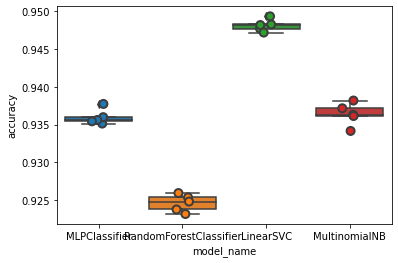

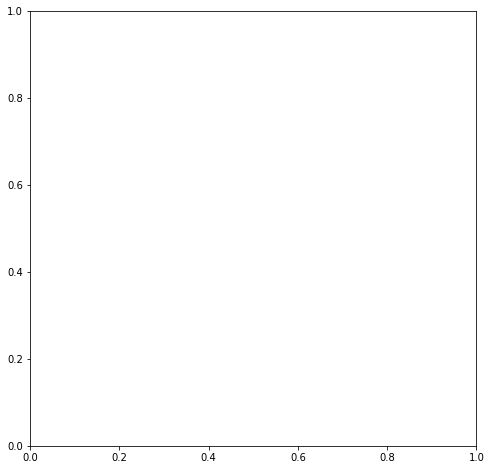

In [102]:
models = [
    MLPClassifier(hidden_layer_sizes=(5, 2), random_state=1),
    RandomForestClassifier(random_state=1),
    LinearSVC(random_state=1),
    MultinomialNB(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

tweetInputsVectorized = CountVectorizer(ngram_range=(1, 2)).fit_transform(tweetInputs)

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, tweetInputsVectorized, tweetOutputs, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

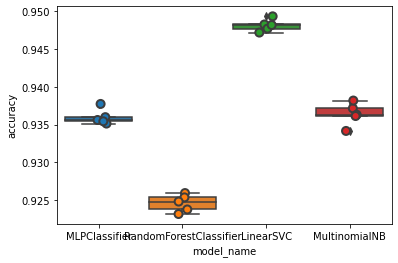

In [103]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [104]:
cv_df

,model_name,fold_idx,accuracy
0,MLPClassifier,0,0.935125
1,MLPClassifier,1,0.935975
2,MLPClassifier,2,0.937725
3,MLPClassifier,3,0.935600
4,MLPClassifier,4,0.935425
5,RandomForestClassifier,0,0.925925
6,RandomForestClassifier,1,0.923150
7,RandomForestClassifier,2,0.925350
8,RandomForestClassifier,3,0.923750
9,RandomForestClassifier,4,0.924800


So perhaps in future, upgrading HumourDetector's brain to a LinearSVC model would be beneficial.